# Code Executor - development notebook

## Docker container space

### Build and run

In [88]:
# Build image
!docker build . --quiet --tag code-executor:latest

sha256:0032f9604a88d23c5bc4ae54ed6023d6edb0ae5154e076b5164be8dfe05e8ef7


In [89]:
# Run container
!docker run -d -p 8080:8080 -e AWS_REGION=us-west-2 -e AWS_DEFAULT_REGION=us-west-2 --name test-code-executor code-executor:latest --host 0.0.0.0 --kms "alias/codenator-kms"

463d4c4eccc957d0b63998d7ad37b6a65a5e4b89afa39a965ff8b41bb5f65c14


In [101]:
# check container logs
!docker logs test-code-executor

/code/app/main.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/opt/conda/lib/python3.11/site-packages/IPython/paths.py:62: UserWarning: IPython dir '/home/jovyan/.ipython' is not a writable location, using a temp directory.
  warn("IPython dir '{0}' is not a writable location,"
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [87]:
# kill and remove container
!docker kill test-code-executor && docker rm test-code-executor

test-code-executor
test-code-executor


In [78]:
# remove container
!docker rm test-code-executor

test-code-executor


In [37]:
# list contexts to get docker host DNS
!docker context ls

NAME                             DESCRIPTION                               DOCKER ENDPOINT                                     ERROR
default                          Current DOCKER_HOST based configuration   unix:///var/run/docker.sock                         
m5.large_i-032a68457470949e6 *                                             tcp://ip-10-3-1-6.us-west-2.compute.internal:1111   


### Test container

In [166]:
import boto3
import base64

class EncryptorClass:
    def __init__(self, key_id):
        self.kms_client = boto3.client("kms")
        self.key_id = key_id
    def encrypt(self, text):
        ret = self.kms_client.encrypt(
            KeyId=self.key_id,
            Plaintext=text
        )
        return base64.b64encode(ret["CiphertextBlob"]).decode()
    def decrypt(self, cipher_text_blob):
        ret = self.kms_client.decrypt(
            KeyId=self.key_id,
            CiphertextBlob=base64.b64decode(cipher_text_blob)
        )
        return ret["Plaintext"].decode()

In [167]:
import requests
import json

cypher = EncryptorClass("alias/codenator-kms")
# IP from docker context when using Studio Docker CLI extension
host_ip = "ip-10-3-1-85.us-west-2.compute.internal"
port = 8080
code = "print(\"Hello ok\")"
code_blob = cypher.encrypt(code)
data = {
    "code": code_blob
}
url = f"http://{host_ip}:{port}/execute_code"
requests.post(url=url, data=json.dumps(data)).text

'{"output":"Hello ok","error":false}'

In [156]:
base64.b64decode(code_blob)

b'\x01\x02\x02\x00x\xf7\x81\xe76[\xa9\xc5\xe0\xa2A\xde\xe1Q\xebm\x194\x8c\xe93T\xf8\xdf\x93a\x97(@\x1c\x14\xfcQ\x01\x92\xd1\xc7\xc8]\xef\x81\x11\xff\x07\x0b@/p\x81\xce\x00\x00\x00o0m\x06\t*\x86H\x86\xf7\r\x01\x07\x06\xa0`0^\x02\x01\x000Y\x06\t*\x86H\x86\xf7\r\x01\x07\x010\x1e\x06\t`\x86H\x01e\x03\x04\x01.0\x11\x04\x0cU9\xb5\xea[\xde\xfd\x1bM\x81\xf6l\x02\x01\x10\x80,\x05Mti\x01\x03\xda\xb9\xd2D\xb6\xaa\x18\xed\xa81\xcf\x8c\xc9\xa9\xae\xb5r\x04z@\xa9\xe7\xb9V\x9c\xd3\xd4\x0f~\xee\xc5\xde\xf2\x10\xcf\x9a\xb3\x1f'

In [157]:
code_blob

'AQICAHj3gec2W6nF4KJB3uFR620ZNIzpM1T435NhlyhAHBT8UQGS0cfIXe+BEf8HC0AvcIHOAAAAbzBtBgkqhkiG9w0BBwagYDBeAgEAMFkGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMVTm16lve/RtNgfZsAgEQgCwFTXRpAQPaudJEtqoY7agxz4zJqa61cgR6QKnnuVac09QPfu7F3vIQz5qzHw=='

In [87]:
%%bash -s $host_ip
curl http://${1}:8080/ping

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    22  100    22    0     0   3498      0 --:--:-- --:--:-- --:--:--  3666


{"Health_Check":"200"}

In [117]:
%%bash -s $host_ip
curl http://${1}:8080/execute_code -X POST -d \"{'code': b'\x01\x02\x02\x00x\xf7\x81\xe76[\xa9\xc5\xe0\xa2A\xde\xe1Q\xebm\x194\x8c\xe93T\xf8\xdf\x93a\x97(@\x1c\x14\xfcQ\x01`\xd6\xd2\x04\x8b&\x11B\xf8T\x12\xe3\xd8\xaa\x82\xdc\x00\x00\x00o0m\x06\t*\x86H\x86\xf7\r\x01\x07\x06\xa0`0^\x02\x01\x000Y\x06\t*\x86H\x86\xf7\r\x01\x07\x010\x1e\x06\t`\x86H\x01e\x03\x04\x01.0\x11\x04\x0c\xdaC\x1b\xeb\t\x89\xacJ0\xb3^\xf4\x02\x01\x10\x80,\xfc\x98U\xb3\x8e\xa2\x82\x98SpM\x00\xba\xc2\xc6\xd8O\xbeI\x8dh\xef\x16\x8bx)M\x958\n(\x06\x9fO\r\xc2\xd3gp\xea44\xf1\xe9'}\"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1020  100  1013  100     7   353k   2499 --:--:-- --:--:-- --:--:--  498k
curl: (3) bad range specification in URL position 33:
b\x01\x02\x02\x00x\xf7\x81\xe76[\xa9\xc5\xe0\xa2A\xde\xe1Q\xebm\x194\x8c\xe93T\xf8\xdf\x93a\x97(@\x1c\x14\xfcQ\x01`\xd6\xd2\x04\x8b&\x11B\xf8T\x12\xe3\xd8\xaa\x82\xdc\x00\x00\x00o0m\x06\t*\x86H\x86\xf7\r\x01\x07\x06\xa0`0^\x02\x01\x000Y\x06\t*\x86H\x86\xf7\r\x01\x07\x010\x1e\x06\t`\x86H\x01e\x03\x04\x01.0\x11\x04\x0c\xdaC\x1b\xeb\t\x89\xacJ0\xb3^\xf4\x02\x01\x10\x80,\xfc\x98U\xb3\x8e\xa2\x82\x98SpM\x00\xba\xc2\xc6\xd8O\xbeI\x8dh\xef\x16\x8bx)M\x958\n(\x06\x9fO\r\


{"error":"An error occurred: Unterminated string starting at: line 1 column 1 (char 0)","stacktrace":"Traceback (most recent call last):\n  File \"/code/app/main.py\", line 43, in execute_code\n    params = await request.json()\n             ^^^^^^^^^^^^^^^^^^^^\n  File \"/opt/conda/lib/python3.11/site-packages/starlette/requests.py\", line 244, in json\n    self._json = json.loads(body)\n                 ^^^^^^^^^^^^^^^^\n  File \"/opt/conda/lib/python3.11/json/__init__.py\", line 346, in loads\n    return _default_decoder.decode(s)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File \"/opt/conda/lib/python3.11/json/decoder.py\", line 337, in decode\n    obj, end = self.raw_decode(s, idx=_w(s, 0).end())\n               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File \"/opt/conda/lib/python3.11/json/decoder.py\", line 353, in raw_decode\n    obj, end = self.scan_once(s, idx)\n               ^^^^^^^^^^^^^^^^^^^^^^\njson.decoder.JSONDecodeError: Unterminated string starting at: line 1 column 1

CalledProcessError: Command 'b'curl http://${1}:8080/execute_code -X POST -d \\"{\'code\': b\'\\x01\\x02\\x02\\x00x\\xf7\\x81\\xe76[\\xa9\\xc5\\xe0\\xa2A\\xde\\xe1Q\\xebm\\x194\\x8c\\xe93T\\xf8\\xdf\\x93a\\x97(@\\x1c\\x14\\xfcQ\\x01`\\xd6\\xd2\\x04\\x8b&\\x11B\\xf8T\\x12\\xe3\\xd8\\xaa\\x82\\xdc\\x00\\x00\\x00o0m\\x06\\t*\\x86H\\x86\\xf7\\r\\x01\\x07\\x06\\xa0`0^\\x02\\x01\\x000Y\\x06\\t*\\x86H\\x86\\xf7\\r\\x01\\x07\\x010\\x1e\\x06\\t`\\x86H\\x01e\\x03\\x04\\x01.0\\x11\\x04\\x0c\\xdaC\\x1b\\xeb\\t\\x89\\xacJ0\\xb3^\\xf4\\x02\\x01\\x10\\x80,\\xfc\\x98U\\xb3\\x8e\\xa2\\x82\\x98SpM\\x00\\xba\\xc2\\xc6\\xd8O\\xbeI\\x8dh\\xef\\x16\\x8bx)M\\x958\\n(\\x06\\x9fO\\r\\xc2\\xd3gp\\xea44\\xf1\\xe9\'}\\"\n'' returned non-zero exit status 3.

In [59]:
# Test broken code execution
%%bash -s $host_ip
curl ${1}:8080/execute_code -X POST -d '{"code": "print(\"Hello ok)"}'

SyntaxError: invalid syntax (3883501092.py, line 3)

In [60]:
# test working code execution
%%bash -s $host_ip
curl -X POST ${1}:8080/execute_code -d '{"code": "print(\"Hello ok\")", "timeout": 10}'

SyntaxError: invalid syntax (3587098348.py, line 3)

In [8]:
# test variable persistance
%%bash -s $host_ip
curl -X POST ${1}:8080/execute_code -d '{"code": "a=10", "timeout": 10}'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    58  100    27  100    31   3287   3774 --:--:-- --:--:-- --:--:--  7250


{"output":"","error":false}

In [9]:
# test variable persistance
%%bash -s $host_ip
curl -X POST ${1}:8080/execute_code -d '{"code": "print(a)", "timeout": 10}'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    64  100    29  100    35   3200   3862 --:--:-- --:--:-- --:--:--  8000


{"output":"10","error":false}

In [10]:
# test restart kernel
%%bash -s $host_ip
curl -X POST ${1}:8080/restart_kernel -d '{"code": "print(\"Hello ok\")", "timeout": 10, "kernel_name": "ir"}'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   114  100    47  100    67    375    534 --:--:-- --:--:-- --:--:--   912


{"output":"Kernel ir restarted!","error":false}

In [11]:
# test listing kernel specs
%%bash -s $host_ip
curl ${1}:8080/list_kernel_specs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   349  100   349    0     0  37934      0 --:--:-- --:--:-- --:--:-- 43625


{"python3":{"display_name":"Python 3 (ipykernel)","language":"python"},"ir":{"display_name":"R","language":"R"},"julia-1.9":{"display_name":"Julia 1.9.3","language":"julia"},"javascript":{"display_name":"JavaScript (Node.js)","language":"javascript"},"bash":{"display_name":"Bash","language":"bash"},"java":{"display_name":"Java","language":"java"}}

In [75]:
host_ip = "internal-codenator-899847730.us-west-2.elb.amazonaws.com"
host_ip = "ip-10-3-1-6.us-west-2.compute.internal"

In [94]:
# test java code
python_code = """import yfinance as yf
import matplotlib.pyplot as plt

amzn = yf.Ticker("AMZN")
hist = amzn.history(period="1y")

plt.plot(hist['Close'])
plt.title('Amazon Stock Price Last Year')
plt.xlabel('Date') 
plt.ylabel('Price ($)')
"""
# plt.savefig('tmp/amzn_price.png')
# """

#java_code += "Main.main(new String[] {})"

In [95]:
class EncryptorClass:
    def __init__(self, key_id):
        self.kms_client = boto3.client("kms")
        self.key_id = key_id
    def encrypt(self, text):
        ret = self.kms_client.encrypt(
            KeyId=self.key_id,
            Plaintext=text
        )
        return base64.b64encode(ret["CiphertextBlob"]).decode()
    def decrypt(self, cipher_text_blob):
        ret = self.kms_client.decrypt(
            KeyId=self.key_id,
            CiphertextBlob=base64.b64decode(cipher_text_blob)
        )
        return ret["Plaintext"].decode()

In [96]:
import requests
import json
import boto3
import base64
import matplotlib as plt

enc = EncryptorClass(key_id="alias/codenator-kms")
java_code_blob = enc.encrypt(python_code)
data = {"code": java_code_blob, "timeout": 10, "kernel_name": "python"}
req = requests.post(f"http://{host_ip}:8080/execute_code", data=json.dumps(data)).text



In [97]:
req

'{"output":"Text(0, 0.5, \'Price ($)\')","error":false,"files":[]}'

In [43]:
import requests
import json
data = {"code": "Main.main(new String[] {\"\"})", "timeout": 10, "kernel_name": "java"}
print(data)
requests.post(f"http://{host_ip}:8080/execute_code", data=json.dumps(data)).text

{'code': 'Main.main(new String[] {""})', 'timeout': 10, 'kernel_name': 'java'}


'{"output":"Hello World!","error":false}'

In [21]:
%%bash -s $host_ip $java_code
echo ${2}
data='{"code": "'${2}'", "timeout": 10, "kernel_name": "java"}'
echo $data
curl -X POST ${1}:8080/execute_code -d ${data}

public
{"code": "public", "timeout": 10, "kernel_name": "java"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    29  100    21  100     8   5312   2023 --:--:-- --:--:-- --:--:--  9666
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: "public",
curl: (3) URL using bad/illegal format or missing URL
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: 10,
curl: (3) URL using bad/illegal format or missing URL
curl: (3) unmatched close brace/bracket in URL position 7:
"java"}
      ^


Internal Server Error

CalledProcessError: Command 'b'echo ${2}\ndata=\'{"code": "\'${2}\'", "timeout": 10, "kernel_name": "java"}\'\necho $data\ncurl -X POST ${1}:8080/execute_code -d ${data}\n'' returned non-zero exit status 3.

In [219]:
%%bash -s $host_ip
curl -X POST ${1}:8080/execute_code -d '{"code": "echo 1", "timeout": 10, "kernel_name": "bash"}'

{"output":"1","error":false}

In [12]:
%%bash -s $host_ip
curl -X POST ${1}:8080/execute_code -d '{"code": "(int) eval(\"1+2\")+3", "timeout": 10, "kernel_name": "java"}'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    99  100    28  100    71     26     66  0:00:01  0:00:01 --:--:--    93


{"output":"6","error":false}

In [246]:
%%bash -s $host_ip
curl -X POST ${1}:8080/execute_code -d '{"code": "console.log(\"Hello World\");", "timeout": 10, "kernel_name": "javascript"}'


{"output":"Hello World","error":false}

In [19]:
%%bash -s $host_ip
curl ${1}:8080/list_kernel_specs

curl: (6) Could not resolve host: ip-172-31-65-185.ap-southeast-2.compute.internal


In [45]:
%%bash -s $host_ip
curl -X POST ${1}:8080/execute_code -d '{"code": "numbers <- c(1, 4, 7, 3, 2)\navg <- mean(numbers)\nprint(avg)", "timeout": 10, "kernel_name": "ir"}'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   143  100    34  100   109    393   1260 --:--:-- --:--:-- --:--:--  1662


{"output":"[1] 3.4","error":false}

In [40]:
!A=$"numbers <- c(1, 4, 7, 3, 2)\\navg <- mean(numbers)\nprint(avg)"; echo $A

numbers <- c(1, 4, 7, 3, 2)\navg <- mean(numbers)\nprint(avg)


In [ ]:
%%bash -s $host_ip
curl -X POST ${1}:8080/execute_code -d '{"code": "print(\"Hello World!\")", "timeout": 10, "kernel_name": "ir"}'

In [3]:
from jupyter_client import run_kernel

In [4]:
!jupyter kernelspec list

Available kernels:
  python3    /opt/conda/share/jupyter/kernels/python3


In [34]:
a = run_kernel(kernel_name="python3")

In [29]:
a.__dict__

{'gen': <generator object run_kernel at 0x7f567824b1b0>,
 'func': <function jupyter_client.manager.run_kernel(**kwargs: Any) -> Iterator[jupyter_client.client.KernelClient]>,
 'args': (),
 'kwds': {'kernel_name': 'python3'},
 '__doc__': 'Context manager to create a kernel in a subprocess.\n\n    The kernel is shut down when the context exits.\n\n    Returns\n    -------\n    kernel_client: connected KernelClient instance\n    '}

In [35]:
a1 = next(a.gen)
print(a1.execute("print('hello')"))
while True:
    try:
        msg = a1.get_iopub_msg(timeout=20)

        msg_type = msg["header"]["msg_type"]
        content = msg["content"]

        if msg_type == "execute_result":
            outputs.append(content["data"])
        elif msg_type == "stream":
            outputs.append(content["text"])
        elif msg_type == "error":
            error_flag = True
            outputs.append(content["traceback"])

        # If the execution state of the kernel is idle, it means the cell finished executing
        if msg_type == "status" and content["execution_state"] == "idle":
            break
    except:
        break
print(msg)

3ecbd2d1-1c918faad191aa2ba8d110aa_1031_2
{'header': {'msg_id': '028c91b8-c7e3980990078315a2ee15b2_1822_9', 'msg_type': 'stream', 'username': 'username', 'session': '028c91b8-c7e3980990078315a2ee15b2', 'date': datetime.datetime(2023, 11, 16, 4, 15, 36, 317538, tzinfo=tzlocal()), 'version': '5.3'}, 'msg_id': '028c91b8-c7e3980990078315a2ee15b2_1822_9', 'msg_type': 'stream', 'parent_header': {'msg_id': '3ecbd2d1-1c918faad191aa2ba8d110aa_1031_2', 'msg_type': 'execute_request', 'username': 'username', 'session': '3ecbd2d1-1c918faad191aa2ba8d110aa', 'date': datetime.datetime(2023, 11, 16, 4, 15, 36, 306969, tzinfo=tzlocal()), 'version': '5.3'}, 'metadata': {}, 'content': {'name': 'stdout', 'text': 'hello\n'}, 'buffers': []}


In [31]:
a

In [ ]:
class JupyterCell:
    def clean_output(self, outputs):
        outputs_only_str = list()
        for i in outputs:
            if type(i) == dict:
                if "text/plain" in list(i.keys()):
                    outputs_only_str.append(i["text/plain"])
            elif type(i) == str:
                outputs_only_str.append(i)
            elif type(i) == list:
                error_msg = "\n".join(i)
                error_msg = re.sub(r"\x1b\[.*?m", "", error_msg)
                outputs_only_str.append(error_msg)

        return "\n".join(outputs_only_str).strip()
    def run_cell

In [71]:
class JupyterNotebook:
    def __init__(self, kernel_name: str = "python3", startup_timeout: float = 60):
        self.kc = run_kernel(kernel_name=kernel_name).gen

    def clean_output(self, outputs):
        outputs_only_str = list()
        for i in outputs:
            if type(i) == dict:
                if "text/plain" in list(i.keys()):
                    outputs_only_str.append(i["text/plain"])
            elif type(i) == str:
                outputs_only_str.append(i)
            elif type(i) == list:
                error_msg = "\n".join(i)
                error_msg = re.sub(r"\x1b\[.*?m", "", error_msg)
                outputs_only_str.append(error_msg)

        return "\n".join(outputs_only_str).strip()

    def run_cell(self, code_string, timeout=10):
        # Execute the code and get the execution count
        outputs = []
        error_flag = False
        client = next(self.kc)
        msg_id = client.execute(code_string)

        while True:
            try:
                msg = client.get_iopub_msg(timeout=timeout)

                msg_type = msg["header"]["msg_type"]
                content = msg["content"]

                if msg_type == "execute_result":
                    outputs.append(content["data"])
                elif msg_type == "stream":
                    outputs.append(content["text"])
                elif msg_type == "error":
                    error_flag = True
                    outputs.append(content["traceback"])

                # If the execution state of the kernel is idle, it means the cell finished executing
                if msg_type == "status" and content["execution_state"] == "idle":
                    break
            except:
                print("here")
                break

        return self.clean_output(outputs), error_flag
    
s = JupyterNotebook()
s.run_cell("print('Hello World!')", 20) 

('Hello World!', False)

In [17]:
!aws kms encrypt --plaintext "here" --key-id alias/codenator-kms

{
    "CiphertextBlob": "AQICAHj3gec2W6nF4KJB3uFR620ZNIzpM1T435NhlyhAHBT8UQGOk4lcSioVCNmjVqumURmZAAAAYjBgBgkqhkiG9w0BBwagUzBRAgEAMEwGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM+i5+mfUfCH1SyH8aAgEQgB/MFKYReUOaiKMNM4GftNjNoYz5SW9eLiLJi3vED0uz",
    "KeyId": "arn:aws:kms:us-west-2:871623330196:key/6438549b-def7-4035-92b8-00e6d1d534bf",
    "EncryptionAlgorithm": "SYMMETRIC_DEFAULT"
}


In [19]:
!aws kms decrypt --ciphertext-blob fileb://<(echo  "AQICAHj3gec2W6nF4KJB3uFR620ZNIzpM1T435NhlyhAHBT8UQGOk4lcSioVCNmjVqumURmZAAAAYjBgBgkqhkiG9w0BBwagUzBRAgEAMEwGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM+i5+mfUfCH1SyH8aAgEQgB/MFKYReUOaiKMNM4GftNjNoYz5SW9eLiLJi3vED0uz" | base64 -d) --key-id alias/codenator-kms --output text --query Plaintext | base64 -d

here

In [49]:
import boto3

input_text = "some text"

class EncryptorClass:
    def __init__(self, key_id):
        self.kms_client = boto3.client("kms")
        self.key_id = key_id
    def encrypt(self, text):
        ret = self.kms_client.encrypt(
            KeyId=self.key_id,
            Plaintext=text
        )
        return ret["CiphertextBlob"]
    def decrypt(self, cipher_text_blob):
        ret = self.kms_client.decrypt(
            KeyId=self.key_id,
            CiphertextBlob=cipher_text_blob
        )
        return ret["Plaintext"].decode()
    

In [93]:
enc = EncryptorClass("alias/codenator-kms")
blob = enc.encrypt("print(\"Hello ok\")")

In [94]:
enc.decrypt(blob)

'print("Hello ok")'

In [95]:
blob

b'\x01\x02\x02\x00x\xf7\x81\xe76[\xa9\xc5\xe0\xa2A\xde\xe1Q\xebm\x194\x8c\xe93T\xf8\xdf\x93a\x97(@\x1c\x14\xfcQ\x01`\xd6\xd2\x04\x8b&\x11B\xf8T\x12\xe3\xd8\xaa\x82\xdc\x00\x00\x00o0m\x06\t*\x86H\x86\xf7\r\x01\x07\x06\xa0`0^\x02\x01\x000Y\x06\t*\x86H\x86\xf7\r\x01\x07\x010\x1e\x06\t`\x86H\x01e\x03\x04\x01.0\x11\x04\x0c\xdaC\x1b\xeb\t\x89\xacJ0\xb3^\xf4\x02\x01\x10\x80,\xfc\x98U\xb3\x8e\xa2\x82\x98SpM\x00\xba\xc2\xc6\xd8O\xbeI\x8dh\xef\x16\x8bx)M\x958\n(\x06\x9fO\r\xc2\xd3gp\xea44\xf1\xe9'

In [114]:
!echo \"{"code": b'\x01\x02\x02\x00x\xf7\x81\xe76[\xa9\xc5\xe0\xa2A\xde\xe1Q\xebm\x194\x8c\xe93T\xf8\xdf\x93a\x97(@\x1c\x14\xfcQ\x01`\xd6\xd2\x04\x8b&\x11B\xf8T\x12\xe3\xd8\xaa\x82\xdc\x00\x00\x00o0m\x06\t*\x86H\x86\xf7\r\x01\x07\x06\xa0`0^\x02\x01\x000Y\x06\t*\x86H\x86\xf7\r\x01\x07\x010\x1e\x06\t`\x86H\x01e\x03\x04\x01.0\x11\x04\x0c\xdaC\x1b\xeb\t\x89\xacJ0\xb3^\xf4\x02\x01\x10\x80,\xfc\x98U\xb3\x8e\xa2\x82\x98SpM\x00\xba\xc2\xc6\xd8O\xbeI\x8dh\xef\x16\x8bx)M\x958\n(\x06\x9fO\r\xc2\xd3gp\xea44\xf1\xe9'}\"

"{code: b\x01\x02\x02\x00x\xf7\x81\xe76[\xa9\xc5\xe0\xa2A\xde\xe1Q\xebm\x194\x8c\xe93T\xf8\xdf\x93a\x97(@\x1c\x14\xfcQ\x01`\xd6\xd2\x04\x8b&\x11B\xf8T\x12\xe3\xd8\xaa\x82\xdc\x00\x00\x00o0m\x06\t*\x86H\x86\xf7\r\x01\x07\x06\xa0`0^\x02\x01\x000Y\x06\t*\x86H\x86\xf7\r\x01\x07\x010\x1e\x06\t`\x86H\x01e\x03\x04\x01.0\x11\x04\x0c\xdaC\x1b\xeb\t\x89\xacJ0\xb3^\xf4\x02\x01\x10\x80,\xfc\x98U\xb3\x8e\xa2\x82\x98SpM\x00\xba\xc2\xc6\xd8O\xbeI\x8dh\xef\x16\x8bx)M\x958\n(\x06\x9fO\r\xc2\xd3gp\xea44\xf1\xe9}"


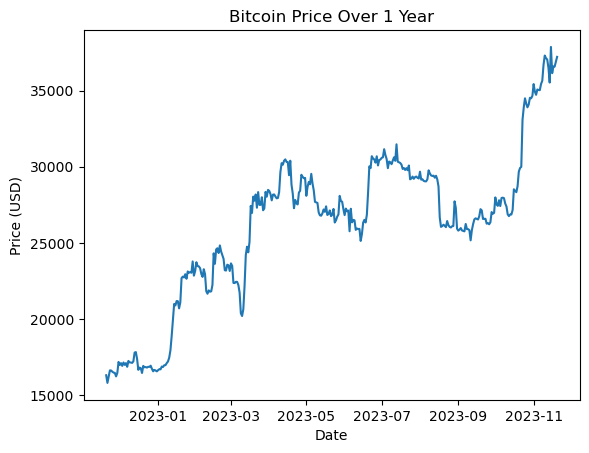

In [25]:
import yfinance as yf
import matplotlib.pyplot as plt

btc = yf.Ticker("BTC-USD")
hist = btc.history(period="1y")
plt.plot(hist['Close'])
plt.title('Bitcoin Price Over 1 Year')
plt.xlabel('Date') 
plt.ylabel('Price (USD)')
plt.savefig('btc_price.png')

In [22]:
!pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/1c/19/bf19123baf16a55fd38cbb100b5a49380b9b6db7279987034689d11254c7/yfinance-0.2.32-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pytz>=2022.5 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c2efa79f8ef9994261fc2/pytz-2023.3.post1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 2.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 1.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 7.9 MB/s eta 0:00:00:00:01
  Created wh

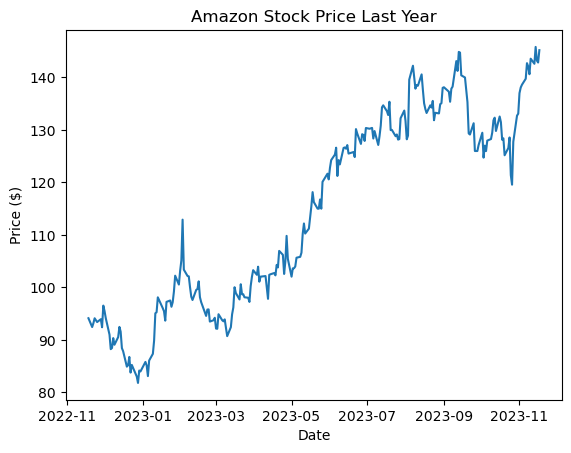

In [28]:
import yfinance as yf
import matplotlib.pyplot as plt

amzn = yf.Ticker("AMZN")
hist = amzn.history(period="1y")

plt.plot(hist['Close'])
plt.title('Amazon Stock Price Last Year')
plt.xlabel('Date') 
plt.ylabel('Price ($)')
plt.savefig('tmp/amzn_price.png')

In [34]:
import os
import base64

path = "app/tmp/"
files = os.listdir(path)
for file in files:
    file_path = os.path.join(path, file)
    if os.path.isfile(file_path):
        with open(file_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read())
            print(encoded_string.decode())
        os.remove(file_path)

iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAACNtUlEQVR4nO3deVyU1f4H8M8wwwz7yCIgioprKm5pImppqai51O2WFUlaZpmledPrL2/dok0t07ppi3rNLC2rm20uuKRZJu6Su2ZuqODGKstsnN8fOA+zwwAzDMzn/XrxauZ5zsxznkHiy/ec8z0yIYQAEREREXkNn7ruABERERG5FwNAIiIiIi/DAJCIiIjIyzAAJCIiIvIyDACJiIiIvAwDQCIiIiIvwwCQiIiIyMswACQiIiLyMgwAiYiIiLwMA0AiIiIiL8MAkIiIiMjLMAAkIiIi8jIMAImIiIi8DANAIiIiIi/DAJCIiIjIyzAAJCIiIvIyDACJiIiIvAwDQCIiIiIvwwCQiIiIyMswACQiIiLyMgwAiYiIiLwMA0AiIiIiL8MAkIiIiMjLMAAkIiIi8jIMAImIiIi8DANAIiIiIi/DAJCIiIjIyzAAJCIiIvIyDACJiIiIvAwDQCIiIiIvwwCQiIiIyMswACQiIiLyMgwAiYiIiLwMA0AiIiIiL8MAkIiIiMjLMAAkIiIi8jIMAIlc4NNPP4VMJjP7aty4MQYMGIA1a9ZYtZfJZEhNTZWeHz16FKmpqTh79qxb+lmb12nZsqXZfQcFBSEhIQGfffZZlV5/9uxZyGQyfPrpp7XWp6rS6XT46KOPkJiYCLVaDX9/f3To0AEvvPACrl+/7vb+VCY1NdXss1YqlYiLi8Nzzz2HvLy8Wr/epUuXkJqaioyMjErbPvPMM/D19cX+/futzmm1WnTu3Blt2rRBUVFRrfeTiCrHAJDIhZYtW4b09HTs2LEDixcvhlwux8iRI/HTTz+ZtUtPT8cTTzwh